In [ ]:
# this notebook calculates the error when using a constant scaling factor instead of our depth-dependent scaling.

In [60]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout, Output, Button, Checkbox,GridBox
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML, clear_output, Javascript
from base64 import b64encode
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

##### DEFINE FUNCTIONS #####

def scaling_factor(NA,n1,n2,lam_0):
    z = np.arange(lam_0,100,0.1)
    n2overn1 = np.divide(n2,n1)
    
    if n2overn1 < 1: eps = np.multiply(-1,np.divide(np.divide(lam_0,4),(np.multiply(z,n2))))
    else: eps = np.divide(np.divide(lam_0,4),(np.multiply(z,n2)))
    eps_term = np.multiply(eps, np.subtract(2,eps))    
    
    m = np.emath.sqrt(np.subtract(np.power(n2,2),np.power(n1,2)))
    
    sf_univ = np.multiply(np.divide(n2,n1),
                          np.divide(1-eps+np.divide(m,n1)*np.emath.sqrt(eps_term),
                                    1-np.multiply(np.divide(n2,n1)**2,eps_term)))
    sf_crit = np.divide(n1-np.emath.sqrt(np.power(n1,2)-np.power(NA,2)),
                        n2-np.emath.sqrt(np.power(n2,2)-np.power(NA,2)))
    
    sf = np.zeros(len(z))
    for i in range(len(sf)):
        if n2overn1 < 1: sf[i] = np.max([np.real(sf_univ[i]),np.real(sf_crit)])
        elif n2overn1 > 1:sf[i] = np.min([np.real(sf_univ[i]),np.real(sf_crit)])
        else: sf[i]=1
    return z,sf,sf_crit,n2overn1

def two_scales(ax1, z, data1, data2,ST,n1,n2,NA,n2overn1,sf_crit,plot_focal_shift):
    
    ax1.set_xlim([0,100])
    ax1.grid(ls=':')
    if plot_focal_shift==True: ax2 = ax1.twinx()

    lns1 = ax1.plot(z, data1,zorder=3000,label='Re-scaling factor')
    ax1.set_xlabel(r'Depth (or AFP) ($\mu$m)')
    ax1.set_ylabel(r'Re-scaling factor $\zeta$ (or AFP/NFP)')
    
    if ST == True:
        ax1.plot(z,Carlsson(z,n2overn1),label='Carlsson 1991')
        ax1.plot(z,Lyakin(z,n2,n1,NA),label=r'Lyakin $et~al.$ 2017')
        ax1.plot(z,diel_median(z,n1,n2,NA),label=r'Diel $et~al.$ 2020 (median)')
        if n2 >= NA: 
            ax1.plot(z,diel_mean(z,n1,n2,NA),label=r'Diel $et~al.$ 2020 (mean)')
            ax1.plot(z,visser(z,n2,n1,NA),label=r'Visser & Oud 1992')
        if n2overn1 >= 1:
            ax1.plot(z,stallinga_high(z,n1,n2,[NA]),label=r'Stallinga 2005',ls='--')
    #set ylimits:
    if n2overn1 > 1:   
        ax1.set_ylim([n2overn1*0.95,1.05*np.real(sf_crit)])
    elif n2overn1 < 1: 
        ymin=np.min([0.9*np.real(sf_crit),0.9*float(Lyakin([1],n2,n1,NA))])
        ymax=n2overn1*1.05
        ax1.set_ylim([ymin,ymax])
    else: ax1.set_ylim(0.5,1.5) 
    
    if plot_focal_shift==True: 
        ax2.plot(z, data2,c='black',label='Focal shift')
        ax2.plot(z,z*(1/Lyakin(z,n2,n1,NA)-1),c='black',label=r'Focal shift (Lyakin $et~al.$ 2017)',ls='--')
        ax2.plot(z,z*(1/Carlsson(z,n2overn1)-1),c='grey',label=r'Focal shift (Carlsson 1991)',ls='-.')
        ax2.set_ylabel(r'Focal shift (or NFP - AFP) ($\mu$m)')
        return ax1, ax2
    else: 
        return ax1,[]
    
    
    
def plot_scaling_factor(NA,n1,n2,lam_0,Scaling_theories,plot_focal_shift):
    z,sf,sf_crit,n2overn1=scaling_factor(NA,n1,n2,lam_0)
    fig,ax=plt.subplots(figsize=(8,5))
    ax1,ax2=two_scales(ax, z, sf, z*(1/sf-1),Scaling_theories,n1,n2,NA,n2overn1,sf_crit,plot_focal_shift)
    lines, labels = ax1.get_legend_handles_labels()
    if plot_focal_shift==False: ax.legend(lines, labels)
    else:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax.legend(lines + lines2, labels + labels2)
    plt.show()

def csv_file(x,y,z):
    # add column names
    string = 'Depth (microns),Re-scaling Factor,Focal Shift (microns)\n'
    for i in range(len(x)): #run over all data points and add to file
        string+=(str(x[i])+','+str(y[i])+','+str(z[i])+'\n')
    return string

def trigger_download(text, filename, kind='text/json'):
    # see https://developer.mozilla.org/en-US/docs/Web/HTTP/Basics_of_HTTP/Data_URIs for details
    content_b64 = b64encode(text.encode()).decode()
    data_url = f'data:{kind};charset=utf-8;base64,{content_b64}'
    js_code = f"""
        var a = document.createElement('a');
        a.setAttribute('download', '{filename}');
        a.setAttribute('href', '{data_url}');
        a.click()
    """
    with download_output:
        clear_output()
        display(HTML(f'<script>{js_code}</script>'))

def download_csv(e=None):
    NA = NA_slider.value
    n1 = n1_slider.value
    n2 = n2_slider.value
    lam_0 = lam_slider.value
    z,sf,_,_=scaling_factor(NA,n1,n2,lam_0)
    trigger_download(csv_file(z,sf,z*(1/sf-1)), 'sf_fs_vs_depth.csv', kind='text/plain')
    
def window_open_button(url):
    with out:
        display(Javascript(f'window.open("{url.tooltip}");'))

##### DEPTH INDEPENDENT THEORIES

def Carlsson(z,n2overn1):
    return np.zeros(len(z)) + n2overn1

def Lyakin(z,n_sample,n_im,NA):
    d = 1
    top = np.add(n_im,np.sqrt(np.subtract(np.power(n_im,2),np.power(NA,2))))
    bottom_1 = np.multiply(4,np.subtract(np.power(n_sample,2),np.power(n_im,2)))
    bottom_2 = np.add(n_im,np.emath.sqrt(np.subtract(np.power(n_im,2),np.power(NA,2))))
    bottom = np.real(np.emath.sqrt(np.add(bottom_1,np.power(bottom_2,2))))
    if bottom == 0: bottom=0.000000000000001
    dz = np.multiply(d,np.divide(top,bottom))
    scaling_factor = np.divide(1,dz)    
    return np.zeros(len(z)) + scaling_factor

def visser(z,n_sample,n_im,NA):
    top = np.tan(np.arcsin(np.divide(NA,n_im)))
    bottom = np.tan(np.arcsin(np.divide(NA,n_sample)))
    sf = np.divide(top,bottom)
    return np.zeros(len(z)) + sf

def diel_mean(z,n_im,n_sample,NA):
    sum=0
    number_of_rays=10000 # paper uses 100, but this is still doable.
    for i in range(number_of_rays):
        k=i+1
        top     =  np.tan(np.arcsin(np.divide((NA*k),(np.multiply(number_of_rays,n_im)))))
        bottom  =  np.tan(np.arcsin(np.divide((NA*k),(np.multiply(number_of_rays,n_sample)))))
        sum +=np.divide(top,bottom)
    return np.zeros(len(z)) + np.divide(sum,number_of_rays)

def diel_median(z,n_im,n_sample,NA):
    top = np.tan(np.arcsin(np.divide(0.5*NA,n_im)))
    bottom = np.tan(np.arcsin(np.divide(0.5*NA,n_sample)))
    return np.zeros(len(z)) + np.divide(top,bottom)

def stallinga_high(z,nn1,nn2,NA):
    if nn1==nn2: 
        return np.ones(len(z))
    alphas=[]
    for i in range(len(NA)):
        alphas.append(-1*(f1f2_av(nn1,nn2,NA[i]) 
                          - f_av(nn1,NA[i]) * f_av(nn2,NA[i])) 
                      / (ff_av(nn1,NA[i]) - f_av(nn1,NA[i])**2))
    d=1
    dz = np.multiply((np.add(alphas,1)),d) #we take delta d as 1
    scaling_factor = np.divide((d-dz),d)
    
    sf = np.divide(-1,alphas)
    return np.zeros(len(z)) + sf

def f_av(nn,NA):
    f=2*(nn**3-(nn**2-NA**2)**(3/2))/(3*NA**2)
    return f

def ff_av(nn,NA):
    ff=nn**2-(NA**2)/2
    return ff

def f1f2_av(nn1,nn2,NA):
    f1f2 = ( (nn1*nn2**3+nn2*nn1**3 - (nn1**2+nn2**2-2*NA**2)*np.sqrt(nn1**2-NA**2)*np.sqrt(nn2**2-NA**2) 
            - ((nn1**2-nn2**2)**2)*np.log( ( np.sqrt(nn1**2-NA**2) - np.sqrt(nn2**2-NA**2) )/ (nn1-nn2) ) )/(4*NA**2) )
    return f1f2




NA:  1.4 	n1:  1.52 	n2:  1.45
axial position error = fs(Loginov) - fs(static)


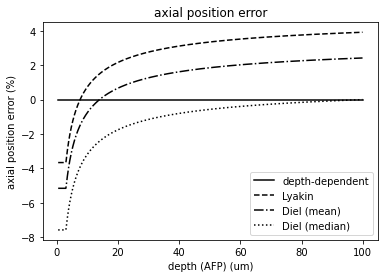

NA:  1.25 	n1:  1.52 	n2:  1.45
axial position error = fs(Loginov) - fs(static)


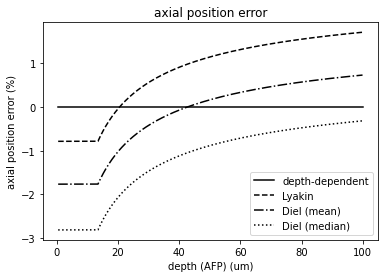

NA:  1.3 	n1:  1.33 	n2:  1.45
axial position error = fs(Loginov) - fs(static)


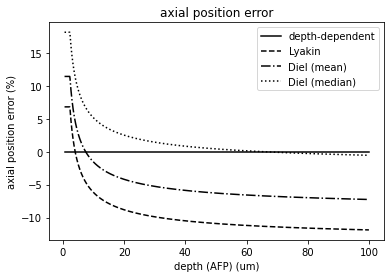

NA:  0.85 	n1:  1.0 	n2:  1.3
axial position error = fs(Loginov) - fs(static)


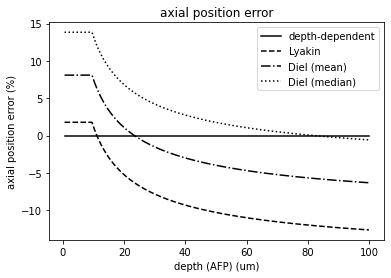

In [64]:
# define scenario's to calculate
NAs = [1.4, 1.25, 1.3, 0.85]
n1s = [1.52, 1.52, 1.33, 1.0]
n2s = [1.45, 1.45, 1.45, 1.3]

lam_0 = 0.52 #nm

#colors=['black','magenta','cyan','red']
colors = ['black','black','black','black']
# re-scaling factor vs depth for each combination:
for s in range(len(NAs)):
    NA = NAs[s]
    n1 = n1s[s]
    n2 = n2s[s]
    print('NA: ',NA,'\tn1: ',n1,'\tn2: ',n2)
    
    z,sf,_,_=scaling_factor(NA,n1,n2,lam_0)
    sf_lyakin = Lyakin(z,n2,n1,NA)
    sf_diel_mean = diel_mean(z,n1,n2,NA)
    sf_diel_median = diel_median(z,n1,n2,NA)
 
    # plt.title('re-scaling factor')
    # plt.plot(z,sf,c=colors[s],label='depth-dependent')
    # plt.plot(z,sf_lyakin,c=colors[s],ls='--',label='Lyakin')
    # plt.plot(z,sf_diel_mean,c=colors[s],ls='-.',label='Diel (mean)')
    # plt.plot(z,sf_diel_median,c=colors[s],ls=':',label='Diel (median)')
    # plt.legend()
    # plt.ylabel('re-scaling factor')
    # plt.xlabel('depth (AFP) (um)')
    # plt.show()
    
    #z is AFP -> real z position of the object
    # sf (rescaling factor) = nfp/afp
    # nfp = sf/afp
    # focal shift = nfp - afp = sf/afp - afp
    
    real_focal_shift = np.multiply(sf,z) - z # based on a depth-dependent scaling factor
    focal_shift_lyakin = np.multiply(sf_lyakin,z) - z # based on a depth-dependent scaling factor
    focal_shift_diel_mean = np.multiply(sf_diel_mean,z) - z # based on a depth-dependent scaling factor
    focal_shift_diel_median = np.multiply(sf_diel_median,z) - z # based on a depth-dependent scaling factor
    
    # plt.title('focal shifts')
    # plt.plot(z,real_focal_shift,c=colors[s],label='depth-dependent')
    # plt.plot(z,focal_shift_lyakin,c=colors[s],ls='--',label='Lyakin')
    # plt.plot(z,focal_shift_diel_mean,c=colors[s],ls='-.',label='Diel (mean)')
    # plt.plot(z,focal_shift_diel_median,c=colors[s],ls=':',label='Diel (median)')
    # plt.ylabel('focal shift (um)')
    # plt.xlabel('depth (AFP) (um)')
    # plt.legend()
    # plt.show()
    
    #estimate errors as compared to dynamic theory
    error_sf = np.divide(real_focal_shift - real_focal_shift,z)*100
    error_lyakin = np.divide(real_focal_shift - focal_shift_lyakin,z)*100
    error_diel_mean = np.divide(real_focal_shift - focal_shift_diel_mean,z)*100
    error_diel_median = np.divide(real_focal_shift - focal_shift_diel_median,z)*100
    
    error_sf_abs = real_focal_shift - real_focal_shift
    error_lyakin_abs = real_focal_shift - focal_shift_lyakin
    error_diel_mean_abs = real_focal_shift - focal_shift_diel_mean
    error_diel_median_abs = real_focal_shift - focal_shift_diel_median
    
    print('axial position error = fs(Loginov) - fs(static)')
    
    fig,axs = plt.subplots(1,2)
    axs[0].plot(z,error_sf_abs,c=colors[s],label='depth-dependent')
    axs[0].plot(z,error_lyakin_abs,c=colors[s],ls='--',label='Lyakin')
    axs[0].plot(z,error_diel_mean_abs,c=colors[s],ls='-.',label='Diel (mean)')
    axs[0].plot(z,error_diel_median_abs,c=colors[s],ls=':',label='Diel (median)')    
    axs[0].set_title('Axial positional error ')
    axs[0].ylabel('axial position error (um)')
    axs[0].xlabel('depth (AFP) (um)')
    
    axs[1].plot(z,error_sf,c=colors[s],label='depth-dependent')
    axs[1].plot(z,error_lyakin,c=colors[s],ls='--',label='Lyakin')
    axs[1].plot(z,error_diel_mean,c=colors[s],ls='-.',label='Diel (mean)')
    axs[1].plot(z,error_diel_median,c=colors[s],ls=':',label='Diel (median)')    
    axs[1].set_title('axial position error')
    axs[1].ylabel('axial position error (%)')
    axs[1].xlabel('depth (AFP) (um)')
    plt.tight_layout()
    plt.show()

    
    plt.title('axial position error')

    plt.ylabel('axial position error (%)')
    plt.xlabel('depth (AFP) (um)')
    plt.legend()
    plt.show()
